In [1]:
import string
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from patsy import dmatrices
import patsy

from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from scipy import interp
from scipy.stats import chi2_contingency, chi2

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Import data

In [2]:
# Create Taylor Swift Dataframe
taylor_df = pd.read_csv('./taylor_swift_IP.csv')
taylor_df.columns = ['unnamed', 'sonnet_index', 'syllables', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       'word_list', 'sonnet_num', 'author', 'polarity', 'subjectivity']

taylor_df['sonnet'] = taylor_df.apply(lambda x: 0, axis=1)

# unnecessary columns

taylor_df = taylor_df.drop('unnamed', axis=1)

taylor_df.head()

,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet
0,1,11,stress,stress,stress,stress,stress,unstress,stress,stress,stress,stress,unstress,missing,"['And', 'I', 'was', 'right', 'there', 'beside'...",1,taylor_swift,0.285714,0.535714,0
1,22,11,stress,stress,stress,stress,stress,stress,stress,stress,unstress,stress,unstress,missing,"['So', 'go', 'and', 'tell', 'your', 'friends',...",22,taylor_swift,0.000000,0.000000,0
2,26,11,stress,stress,stress,stress,unstress,stress,stress,unstress,stress,unstress,stress,missing,"['And', 'if', 'you', 'come', 'around', 'saying...",26,taylor_swift,-0.500000,1.000000,0
3,35,11,stress,stress,stress,stress,stress,stress,stress,stress,unstress,unstress,stress,missing,"['He', 'says', 'he', 'so', 'in', 'love', 'he',...",35,taylor_swift,0.250000,0.800000,0
4,46,11,stress,stress,stress,stress,unstress,stress,stress,stress,stress,stress,stress,missing,"['So', 'I', 'drive', 'home', 'alone', 'as', 'I...",46,taylor_swift,0.000000,0.000000,0


In [3]:
taylor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 20 columns):
sonnet_index    470 non-null int64
syllables       470 non-null int64
s1              470 non-null object
s2              470 non-null object
s3              470 non-null object
s4              470 non-null object
s5              470 non-null object
s6              470 non-null object
s7              470 non-null object
s8              470 non-null object
s9              470 non-null object
s10             470 non-null object
s11             470 non-null object
s12             470 non-null object
word_list       470 non-null object
sonnet_num      470 non-null int64
author          470 non-null object
polarity        470 non-null float64
subjectivity    470 non-null float64
sonnet          470 non-null int64
dtypes: float64(2), int64(4), object(14)
memory usage: 73.5+ KB


In [4]:
# Create BSB Dataframe
bsb_df = pd.read_csv('./bsb_IP.csv')
bsb_df.columns = ['unnamed', 'sonnet_index', 'syllables', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       'word_list', 'sonnet_num', 'author', 'polarity', 'subjectivity']

bsb_df['sonnet'] = bsb_df.apply(lambda x: 0, axis=1)

# unnecessary columns

bsb_df = bsb_df.drop('unnamed', axis=1)

bsb_df.head()

,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet
0,0,11,stress,stress,stress,unstress,stress,unstress,unstress,stress,stress,stress,stress,missing,"['Your', 'ten', 'thousand', 'promises', 'That'...",0,bsb,0.0,0.0,0
1,8,11,stress,stress,unstress,stress,stress,stress,stress,unstress,stress,stress,stress,missing,"['Who', 'wasted', 'my', 'time', 'and', 'money'...",8,bsb,-0.2,0.0,0
2,24,11,stress,stress,stress,unstress,stress,unstress,unstress,stress,stress,stress,stress,missing,"['Your', 'ten', 'thousand', 'promises', 'That'...",24,bsb,0.0,0.0,0
3,27,11,stress,stress,stress,unstress,stress,unstress,unstress,stress,stress,stress,stress,missing,"['Your', 'ten', 'thousand', 'promises', 'That'...",27,bsb,0.0,0.0,0
4,28,11,stress,stress,stress,missing,stress,missing,stress,stress,stress,missing,stress,missing,"['What', 'a', 'lie', '(what', 'a', 'lie)', 'Yo...",28,bsb,0.0,0.0,0


In [5]:
bsb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 20 columns):
sonnet_index    1235 non-null int64
syllables       1235 non-null int64
s1              1235 non-null object
s2              1235 non-null object
s3              1235 non-null object
s4              1235 non-null object
s5              1235 non-null object
s6              1235 non-null object
s7              1235 non-null object
s8              1235 non-null object
s9              1235 non-null object
s10             1235 non-null object
s11             1235 non-null object
s12             1235 non-null object
word_list       1235 non-null object
sonnet_num      1235 non-null int64
author          1235 non-null object
polarity        1235 non-null float64
subjectivity    1235 non-null float64
sonnet          1235 non-null int64
dtypes: float64(2), int64(4), object(14)
memory usage: 193.0+ KB


In [6]:
# Create full_sonnet Dataframe
poems_df = pd.read_csv('./full_sonnet_df.csv')
poems_df.head()
poems_df.columns = ['unnamed0','unnamed1', 'sonnet_index', 'syllables', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12',
       'word_list', 'sonnet_num', 'author', 'polarity', 'subjectivity','sonnet']

# drop unnecessary columns

poems_df = poems_df.drop('unnamed0', axis=1)
poems_df = poems_df.drop('unnamed1', axis=1)

poems_df.head()

,sonnet_index,syllables,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,word_list,sonnet_num,author,polarity,subjectivity,sonnet
0,2,10,unstress,stress,unstress,stress,unstress,stress,unstress,stress,unstress,stress,missing,missing,"['From', 'fairest', 'creatures', 'we', 'desire...",1,Shakespeare,0.00,0.00,1
1,3,11,unstress,stress,stress,stress,unstress,stress,stress,stress,unstress,stress,missing,missing,"['That', 'thereby', 'beauty', 'rose', 'might',...",1,Shakespeare,0.60,0.95,1
2,4,10,stress,stress,unstress,missing,missing,stress,stress,stress,unstress,stress,missing,missing,"['But', 'as', 'the', 'riper', 'should', 'by', ...",1,Shakespeare,0.00,0.00,1
3,5,10,unstress,stress,unstress,stress,stress,stress,unstress,stress,unstress,unstress,missing,missing,"['His', 'tender', 'heir', 'might', 'bear', 'hi...",1,Shakespeare,0.00,0.00,1
4,6,10,stress,stress,stress,unstress,unstress,stress,stress,stress,stress,stress,missing,missing,"['But', 'thou', 'contracted', 'to', 'thine', '...",1,Shakespeare,0.65,0.90,1


In [7]:
# Randomly take subset of the full sonnets data
poems_df = poems_df.drop(poems_df.sample(frac=.65).index)

In [8]:
poems_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1792 entries, 4 to 5115
Data columns (total 20 columns):
sonnet_index    1792 non-null int64
syllables       1792 non-null int64
s1              1792 non-null object
s2              1792 non-null object
s3              1792 non-null object
s4              1792 non-null object
s5              1792 non-null object
s6              1792 non-null object
s7              1792 non-null object
s8              1792 non-null object
s9              1792 non-null object
s10             1792 non-null object
s11             1792 non-null object
s12             1792 non-null object
word_list       1792 non-null object
sonnet_num      1792 non-null int64
author          1761 non-null object
polarity        1792 non-null float64
subjectivity    1792 non-null float64
sonnet          1792 non-null int64
dtypes: float64(2), int64(4), object(14)
memory usage: 294.0+ KB


In [9]:
# Stacking the Taylor Swift, BSB, and Poems dataframes

final_df = pd.concat([taylor_df, bsb_df, poems_df])
final_df.head()
final_df.to_csv('final_df.csv')

In [10]:
final_df.shape

(3497, 20)

# Baseline

In [11]:
print(np.mean(final_df.sonnet))

0.5124392336288247


# Logistic Regression

In [12]:
logreg = LogisticRegression()

formula = 'sonnet ~ syllables + C(s1) + C(s2) + C(s3) + C(s4) + C(s5) + C(s6) + C(s7) + C(s8) + C(s9) + C(s10) + C(s11) + C(s12) + polarity + subjectivity -1'
Y, X = dmatrices(formula, data=final_df)

In [13]:
#Prediction values
# ypred = logreg.predict(X)
# mistakes_df['algorithm'] = ypred

In [14]:
interaction_formula = ''' sonnet ~ syllables + (C(s1) + C(s2) + C(s3) + C(s4) + C(s5) + C(s6) + C(s7) + C(s8) + 
C(s9) + C(s10) + C(s11) + C(s12))**2 + polarity + subjectivity -1'''
Yint, Xint = dmatrices(interaction_formula, data=final_df, return_type='dataframe')
Xint = (Xint - Xint.mean()) / Xint.std()
Xint.dropna(axis=1, inplace=True)

In [15]:
Yint.shape, Xint.shape

((3497, 1), (3497, 286))

In [16]:
Y.shape, X.shape

((3497, 1), (3497, 28))

In [17]:
np.mean(Y)

array(0.51243923)

# Inspect Model 1

## Summary

In [18]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model1 = smf.glm(formula = formula, data=final_df, family=sm.families.Binomial())
my_model1 = model1.fit()
print(my_model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                            GLM   Df Residuals:                     3469
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -322.65
Date:                Sat, 12 Oct 2019   Deviance:                       645.30
Time:                        15:12:52   Pearson chi2:                 6.30e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(s1)[missing]        29.9743      3

## step-wise selection

In [19]:
def step_wise_forward_selected(data, predictors, response, AIC=True):
    """Logistic model designed by forward selection.
    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response
    response: string, name of response column in data
    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by AIC

    inspiration provided by https://planspace.org/20150423-forward_selection_with_statsmodels/
    """
    print("remaining = ", predictors)
    print("response = ", response)
    selected = []
    current_score, best_new_score = 99999, 99999  # set starting scores high so we get lower score
    
    while predictors and current_score == best_new_score:
#         print("new round")
#         print("current_score = ", current_score)
        scores_with_candidates = []
#         print("scores with candidates = ", scores_with_candidates)
        for candidate in predictors:
#             print("candidate = ", candidate)
            formula = "{} ~ {} + 1".format(response,' + '.join(selected + [candidate]))
#             print("candidate formula = ", formula)
            if AIC:
                score = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit().aic
            else:
                score = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit().bic
#             print("score = ", score)
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
#         print("scores with candidates = ", scores_with_candidates)
        best_new_score, best_candidate = scores_with_candidates.pop()
#         print("best new score = ", best_new_score)
#         print("best candidate = ", best_candidate)
        if current_score > best_new_score:
            predictors.remove(best_candidate)
            selected.append(best_candidate)
#             print("selected = ", selected)
            current_score = best_new_score
    
    formula = "{} ~ {} + 1".format(response,' + '.join(selected))
    return formula

### AIC

In [20]:
my_pred = ["syllables","C(s1)","C(s2)","C(s3)","C(s4)","C(s5)","C(s6)","C(s7)","C(s8)","C(s9)","C(s10)","C(s11)","C(s12)","polarity","subjectivity"]
aic_step_formula = step_wise_forward_selected(final_df, my_pred, "sonnet", True)
print(aic_step_formula)

remaining =  ['syllables', 'C(s1)', 'C(s2)', 'C(s3)', 'C(s4)', 'C(s5)', 'C(s6)', 'C(s7)', 'C(s8)', 'C(s9)', 'C(s10)', 'C(s11)', 'C(s12)', 'polarity', 'subjectivity']
response =  sonnet
sonnet ~ C(s11) + C(s1) + C(s3) + C(s5) + C(s7) + C(s12) + C(s9) + syllables + C(s10) + C(s4) + C(s2) + subjectivity + polarity + 1


In [21]:
Ya, Xa = dmatrices(aic_step_formula, data=final_df)

In [22]:
modela = smf.glm(formula = aic_step_formula, data=final_df, family=sm.families.Binomial())
my_modela = modela.fit()
print(my_modela.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                            GLM   Df Residuals:                     3473
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.85
Date:                Sat, 12 Oct 2019   Deviance:                       647.70
Time:                        15:13:00   Pearson chi2:                 7.36e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             29.1520      3

### BIC

In [23]:
my_pred = ["syllables","C(s1)","C(s2)","C(s3)","C(s4)","C(s5)","C(s6)","C(s7)","C(s8)","C(s9)","C(s10)","C(s11)","C(s12)","polarity","subjectivity"]
bic_step_formula = step_wise_forward_selected(final_df, my_pred, "sonnet", False)
print(bic_step_formula)

remaining =  ['syllables', 'C(s1)', 'C(s2)', 'C(s3)', 'C(s4)', 'C(s5)', 'C(s6)', 'C(s7)', 'C(s8)', 'C(s9)', 'C(s10)', 'C(s11)', 'C(s12)', 'polarity', 'subjectivity']
response =  sonnet
sonnet ~ C(s11) + C(s1) + C(s3) + C(s5) + C(s7) + C(s12) + C(s9) + syllables + C(s10) + C(s4) + C(s2) + 1


In [24]:
Yb, Xb = dmatrices(bic_step_formula, data=final_df)

In [25]:
modelb = smf.glm(formula = bic_step_formula, data=final_df, family=sm.families.Binomial())
my_modelb = modelb.fit()
print(my_modelb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                            GLM   Df Residuals:                     3475
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -328.72
Date:                Sat, 12 Oct 2019   Deviance:                       657.44
Time:                        15:13:07   Pearson chi2:                 6.24e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             29.8588      3

## Cross Val Scores

In [26]:
scores1 = cross_val_score(logreg, X, np.ravel(Y), cv=5)
print(scores1)
print(np.mean(scores1))

[0.97571429 0.95571429 0.95135908 0.94706724 0.96280401]
0.9585317800940117


In [27]:
scoresa = cross_val_score(logreg, Xa, np.ravel(Ya), cv=5)
print(scoresa)
print(np.mean(scoresa))

[0.97714286 0.95571429 0.95135908 0.94992847 0.9713877 ]
0.9611064786429594


In [28]:
scoresb = cross_val_score(logreg, Xb, np.ravel(Yb), cv=5)
print(scoresb)
print(np.mean(scoresb))

[0.97142857 0.95571429 0.94992847 0.94706724 0.96280401]
0.9573885142039649


In [30]:
model_features = ['syllables', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 'polarity', 'subjectivity']

# zip(model_features, logreg.coef_)

# len(model_features), len(logreg.coef_[0])
# len(X.design_info.column_names), len(logreg.coef_[0])

## Influencial Points

In [31]:
n=3497
p_a=15
influence_a = my_modela.get_influence()
infl_df_a = influence_a.summary_frame()

resid_df = infl_df_a.sort_values('standard_resid', ascending=False)
resid_df_a = resid_df.loc[abs(resid_df.standard_resid) > 3]
print(len(resid_df_a))

cook_df = infl_df_a.sort_values('cooks_d', ascending=False)
Di = 4/(n-p_a)
cook_df_a = cook_df.loc[abs(cook_df.cooks_d) > Di]
print(len(cook_df_a))

dffit_df = infl_df_a.sort_values('dffits_internal', ascending=False)
dff = 2*((p_a+1)/(n-p_a-1))**0.5
dffit_df_a = dffit_df.loc[abs(dffit_df.dffits_internal) > dff]
print(len(dffit_df_a))

46
242
270


In [32]:
n=3497
p_b=12
influence_b = my_modelb.get_influence()
infl_df_b = influence_b.summary_frame()

resid_df = infl_df_b.sort_values('standard_resid', ascending=False)
resid_df_b = resid_df.loc[abs(resid_df.standard_resid) > 3]
print(len(resid_df_b))

cook_df = infl_df_b.sort_values('cooks_d', ascending=False)
Di = 4/(n-p_b)
cook_df_b = cook_df.loc[abs(cook_df.cooks_d) > Di]
print(len(cook_df_b))

dffit_df = infl_df_b.sort_values('dffits_internal', ascending=False)
dff = 2*((p_b+1)/(n-p_b-1))**0.5
dffit_df_b = dffit_df.loc[abs(dffit_df.dffits_internal) > dff]
print(len(dffit_df_b))

44
243
278


# Predict

In [34]:
logreg.fit(X,np.ravel(Y))
pp = logreg.predict_proba(X)
y_pred_50pct = logreg.predict(X)

# ROC curve

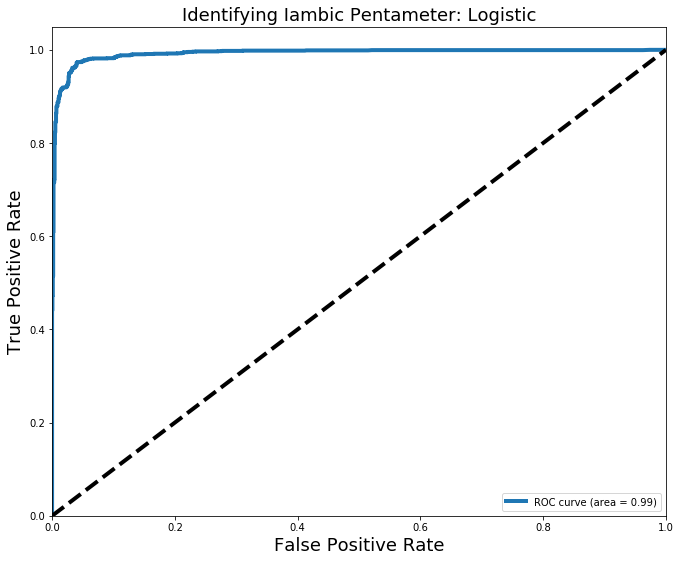

In [35]:
Ytrue = pd.Series(np.ravel(Y))
Y_score = logreg.decision_function(X)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(Ytrue, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Identifying Iambic Pentameter: Logistic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix

In [36]:
Ytrue = pd.Series(np.ravel(Y))
Ypred50 = pd.Series(y_pred_50pct)
pd.crosstab(Ytrue, Ypred50, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0.0,1.0,All
True,,,
0.0,1649,56,1705
1.0,73,1719,1792
All,1722,1775,3497


# Model Evaluation:

### Wald's Test

In [37]:
# Testing for the significance of individual regression coefficients
# Assume Ho: Bi=0 vs Ha: Bi!=0

print(my_model1.pvalues < 0.025) # Use rejection rule Z_s > Z_a/2

C(s1)[missing]         True
C(s1)[stress]          True
C(s1)[unstress]        True
C(s2)[T.stress]        True
C(s2)[T.unstress]      True
C(s3)[T.stress]       False
C(s3)[T.unstress]      True
C(s4)[T.stress]        True
C(s4)[T.unstress]      True
C(s5)[T.stress]        True
C(s5)[T.unstress]      True
C(s6)[T.stress]       False
C(s6)[T.unstress]     False
C(s7)[T.stress]        True
C(s7)[T.unstress]     False
C(s8)[T.stress]       False
C(s8)[T.unstress]     False
C(s9)[T.stress]        True
C(s9)[T.unstress]     False
C(s10)[T.stress]       True
C(s10)[T.unstress]    False
C(s11)[T.stress]       True
C(s11)[T.unstress]     True
C(s12)[T.stress]      False
C(s12)[T.unstress]    False
syllables              True
polarity              False
subjectivity           True
dtype: bool


From the model1 summary above we can see that our significant predictors are S1, S2, S4, S11, and subjectivity. 

### Deviance Chi-Squared Test

In [38]:
# Comparing Reduced vs. Full Model

g_full_model = my_model1.deviance     # values from summary tables above
g_reduced_model = my_modelb.deviance
print(f'Deviance of Full Model: {g_full_model}')
print(f'Deviance of Reduced Model: {g_reduced_model}')

delta_G_squared = g_reduced_model - g_full_model
print(f'Delta G-Squared: {delta_G_squared}')

chi_val = chi2.isf(0.05, 22, loc=0, scale=1) # where df=22 is from reduced model
print(f'Chi-Squared Value: {chi_val}')

Deviance of Full Model: 645.2993417991851
Deviance of Reduced Model: 657.4356048772447
Delta G-Squared: 12.136263078059642
Chi-Squared Value: 33.92443847144379


Thus, since our delta G-squared value is smaller than our chi-squared value, we fail to reject the null hypothesis in favor of the alternative which is our reduced model.

### Pseudo-R-Squared

In [39]:
# Goodness-of-Fit
import statsmodels.api as sm

new_bic = "sonnet ~ C(s11) + C(s1) + C(s7) + C(s3) + C(s5) + syllables + C(s9) + C(s10) + 1"
Y, X = patsy.dmatrices(new_bic, data=final_df)

logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary())

pseudo_r_squared = result.prsquared()

Optimization terminated successfully.
         Current function value: 0.114317
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                          Logit   Df Residuals:                     3481
Method:                           MLE   Df Model:                           15
Date:                Sat, 12 Oct 2019   Pseudo R-squ.:                  0.8350
Time:                        15:18:45   Log-Likelihood:                -399.77
converged:                       True   LL-Null:                       -2422.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             18.6739      2.668      6.999      0.000      13.444      23.904
C(s11

TypeError: 'numpy.float64' object is not callable

In [40]:
new_aic = "sonnet ~ C(s11) + C(s1) + C(s7) + C(s3) + C(s5) + C(s9) + syllables + C(s10) + C(s2) + subjectivity + C(s4) + C(s8) + C(s6) + 1"

Y, X = patsy.dmatrices(new_aic, data=final_df)

logit_model=sm.Logit(Y,X)
result=logit_model.fit()
print(result.summary())

pseudo_r_squared = result.prsquared()

Optimization terminated successfully.
         Current function value: 0.106415
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 sonnet   No. Observations:                 3497
Model:                          Logit   Df Residuals:                     3472
Method:                           MLE   Df Model:                           24
Date:                Sat, 12 Oct 2019   Pseudo R-squ.:                  0.8464
Time:                        15:18:50   Log-Likelihood:                -372.13
converged:                       True   LL-Null:                       -2422.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             19.8955      2.775      7.169      0.000      14.456      25.335
C(s1

TypeError: 'numpy.float64' object is not callable

## Multicolinearity

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif["coefficients"] = result.params
vif["features"] = ["Intercept","C(s11)[T.stress]","C(s11)[T.unstress]","C(s1)[T.stress]","C(s1)[T.unstress]","C(s7)[T.stress]",
                    "C(s7)[T.unstress]","C(s3)[T.stress]","C(s3)[T.unstress]","C(s5)[T.stress]","C(s5)[T.unstress]","C(s9)[T.stress]",
                    "C(s9)[T.unstress]","C(s10)[T.stress]","C(s10)[T.unstress]","C(s2)[T.stress]","C(s2)[T.unstress]","C(s4)[T.stress]",
                    "C(s4)[T.unstress]","C(s8)[T.stress]","C(s8)[T.unstress]","C(s6)[T.stress]","C(s6)[T.unstress]","syllables","subjectivity"]

In [42]:
print(vif)

    VIF Factor  coefficients            features
0   382.751999     19.895532           Intercept
1     2.990072     -5.663567    C(s11)[T.stress]
2     1.545313     -4.038240  C(s11)[T.unstress]
3     5.843346     -0.265656     C(s1)[T.stress]
4     6.131800      2.791288   C(s1)[T.unstress]
5     5.851810     -1.061373     C(s7)[T.stress]
6     5.827488      1.088606   C(s7)[T.unstress]
7     7.787509     -0.681515     C(s3)[T.stress]
8     7.748618      1.628768   C(s3)[T.unstress]
9     7.561388     -2.830825     C(s5)[T.stress]
10    7.595994     -1.276078   C(s5)[T.unstress]
11    4.467312     -1.786815     C(s9)[T.stress]
12    4.600663     -0.582874   C(s9)[T.unstress]
13    2.231064     -1.114312    C(s10)[T.stress]
14    1.868308      0.504495  C(s10)[T.unstress]
15    3.285858     -2.102535     C(s2)[T.stress]
16    3.089458     -2.038476   C(s2)[T.unstress]
17    3.763259     -1.266049     C(s4)[T.stress]
18    3.622923     -2.500231   C(s4)[T.unstress]
19    3.162870     -